In [1]:
import os
import sys

data_fitting_py_files_dir = os.path.abspath("../../py_files/")
sys.path.insert(0, data_fitting_py_files_dir)

helper_func_py_files_dir = os.path.abspath("../../../../vampires_on_sky_calibration/programs/py_files/")
sys.path.insert(0, helper_func_py_files_dir)

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import general
import data_plotting
import reading_data
import instrument_matrices


In [2]:
HWP_angs = np.array([0., 11.25, 22.5, 33.75, 45., 56.25, 67.5, 78.75])
IMR_angs = np.array([45., 57.5, 70., 82.5, 95., 107.5, 120., 132.5])
wavelengths = np.array([610, 670, 720, 760])
angles = [HWP_angs, IMR_angs]

In [3]:
# Last index is for choosing the wavelength

wavelength_index = 0
wavelength = 610

double_differences = np.load("../../../data/20230914/double_diffs_20230914_MBI.npy")[0 : 8, 0 : 8, wavelength_index]
double_sums = np.load("../../../data/20230914/double_sums_20230914_MBI.npy")[0 : 8, 0 : 8, wavelength_index]
double_difference_errs = np.load("../../../data/20230914/double_diff_stds_20230914_MBI.npy")[0 : 8, 0 : 8, wavelength_index]
double_sum_errs = np.load("../../../data/20230914/double_sum_stds_20230914_MBI.npy")[0 : 8, 0 : 8, wavelength_index]
data = np.array([double_differences, double_sums])
stds = np.array([double_difference_errs, double_sum_errs])

reshaped_data = general.reshape_and_flatten(data)
reshaped_stds = general.reshape_and_flatten(stds)

In [4]:
# NOTE: Customized angle bounds for each parameter
IMR_angle_bound = 1
LP_angle_bound = 5
HWP_angle_bound = 5
FLC_angle_bound = (-5, 5)

bounds = ((0, 1), # EM Gain Ratio
          (-1 * LP_angle_bound, LP_angle_bound), # linear polarizer angle (degrees)
          (-1, 1), # delta_FLC (waves)
          (-1, 1), # delta_opt (waves)
          (-1, 1), # delta_derot (waves)
          (0, 0.499999), # delta_HWP (waves)
          FLC_angle_bound, # rot_FLC (degrees)
          (-90, 90), # rot_opt (degrees)
          (-1 * IMR_angle_bound, IMR_angle_bound), # offset_derot (degrees)
          (-1 * HWP_angle_bound, HWP_angle_bound), # offset_HWP (degrees)
          (0, 1)) # epsilon_opt (unitless)

# Plot Initial Guess

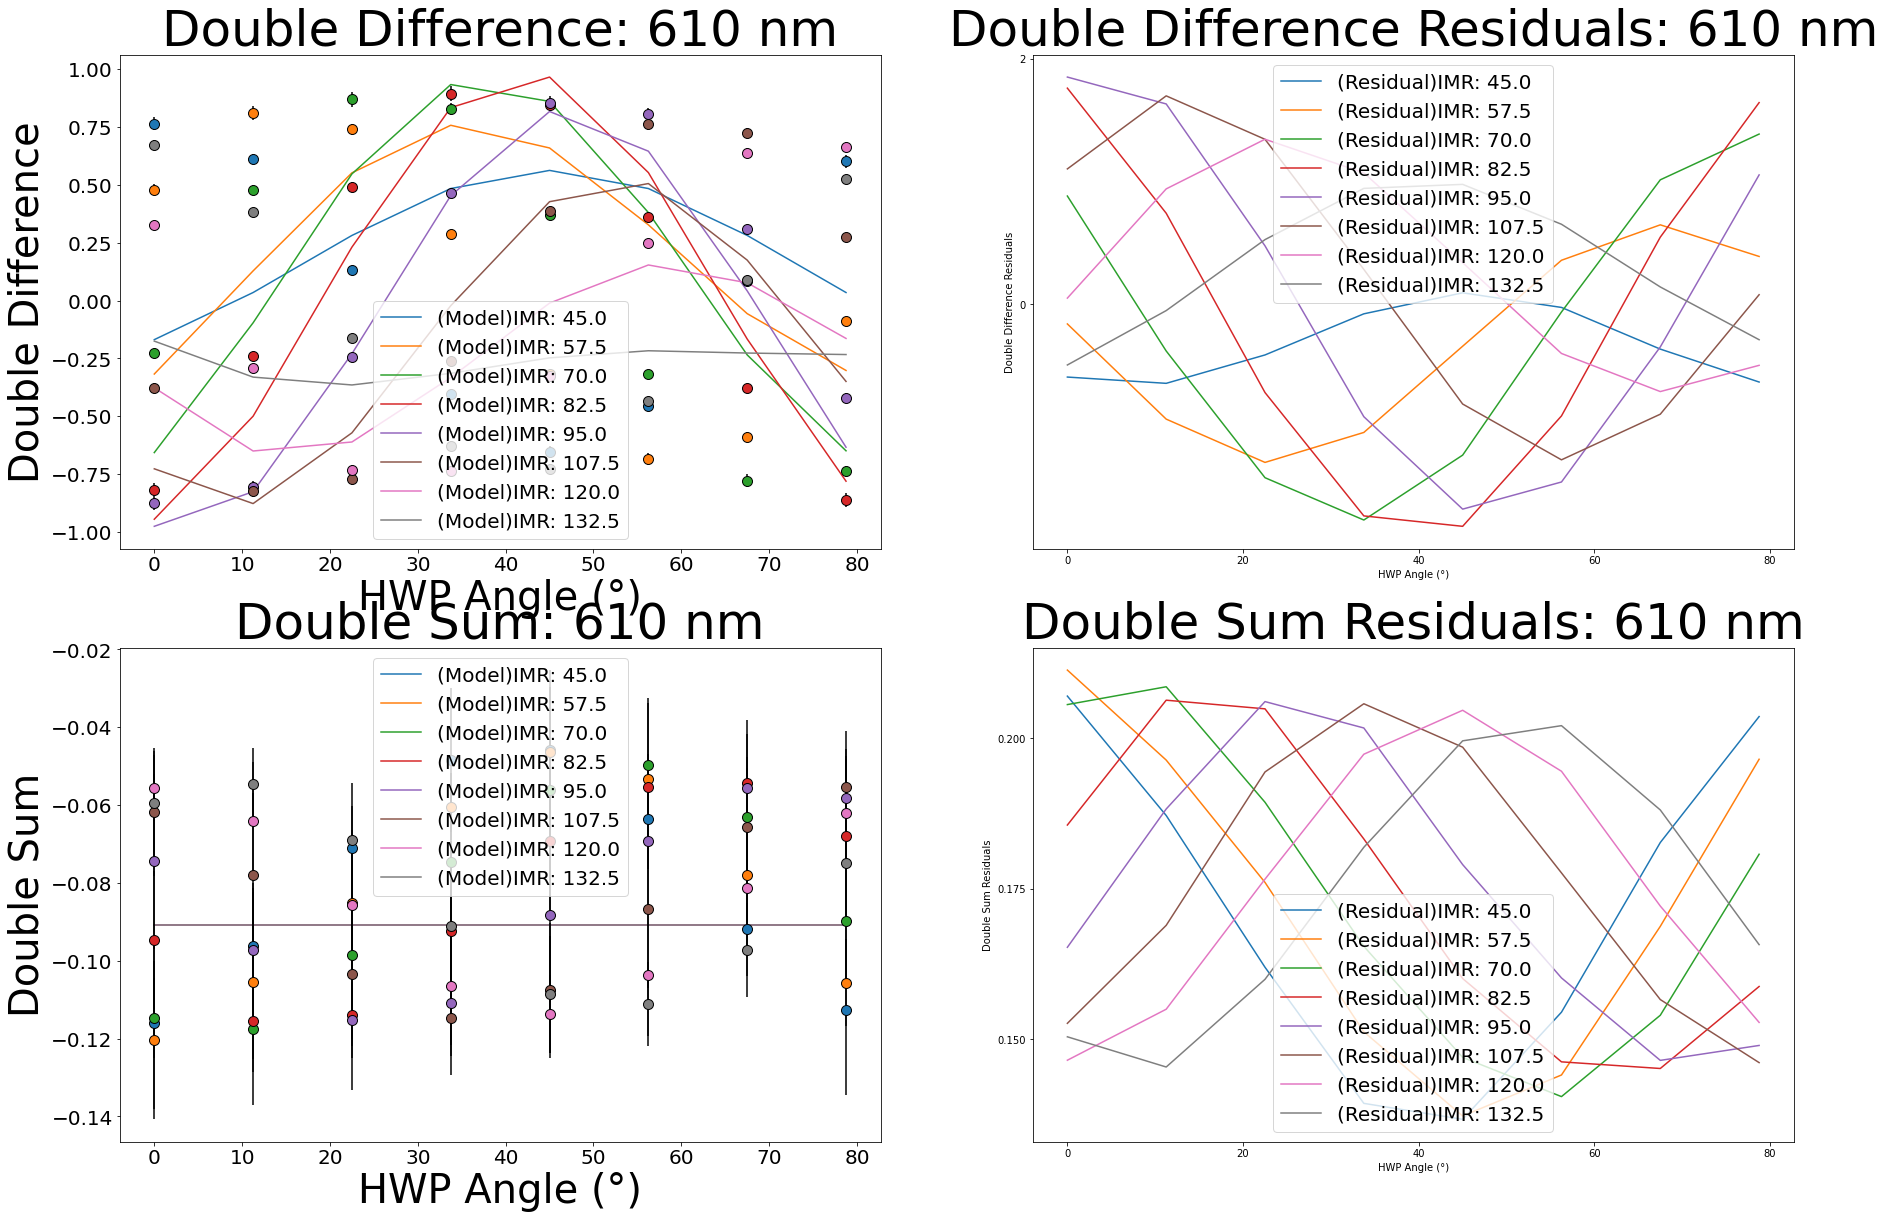

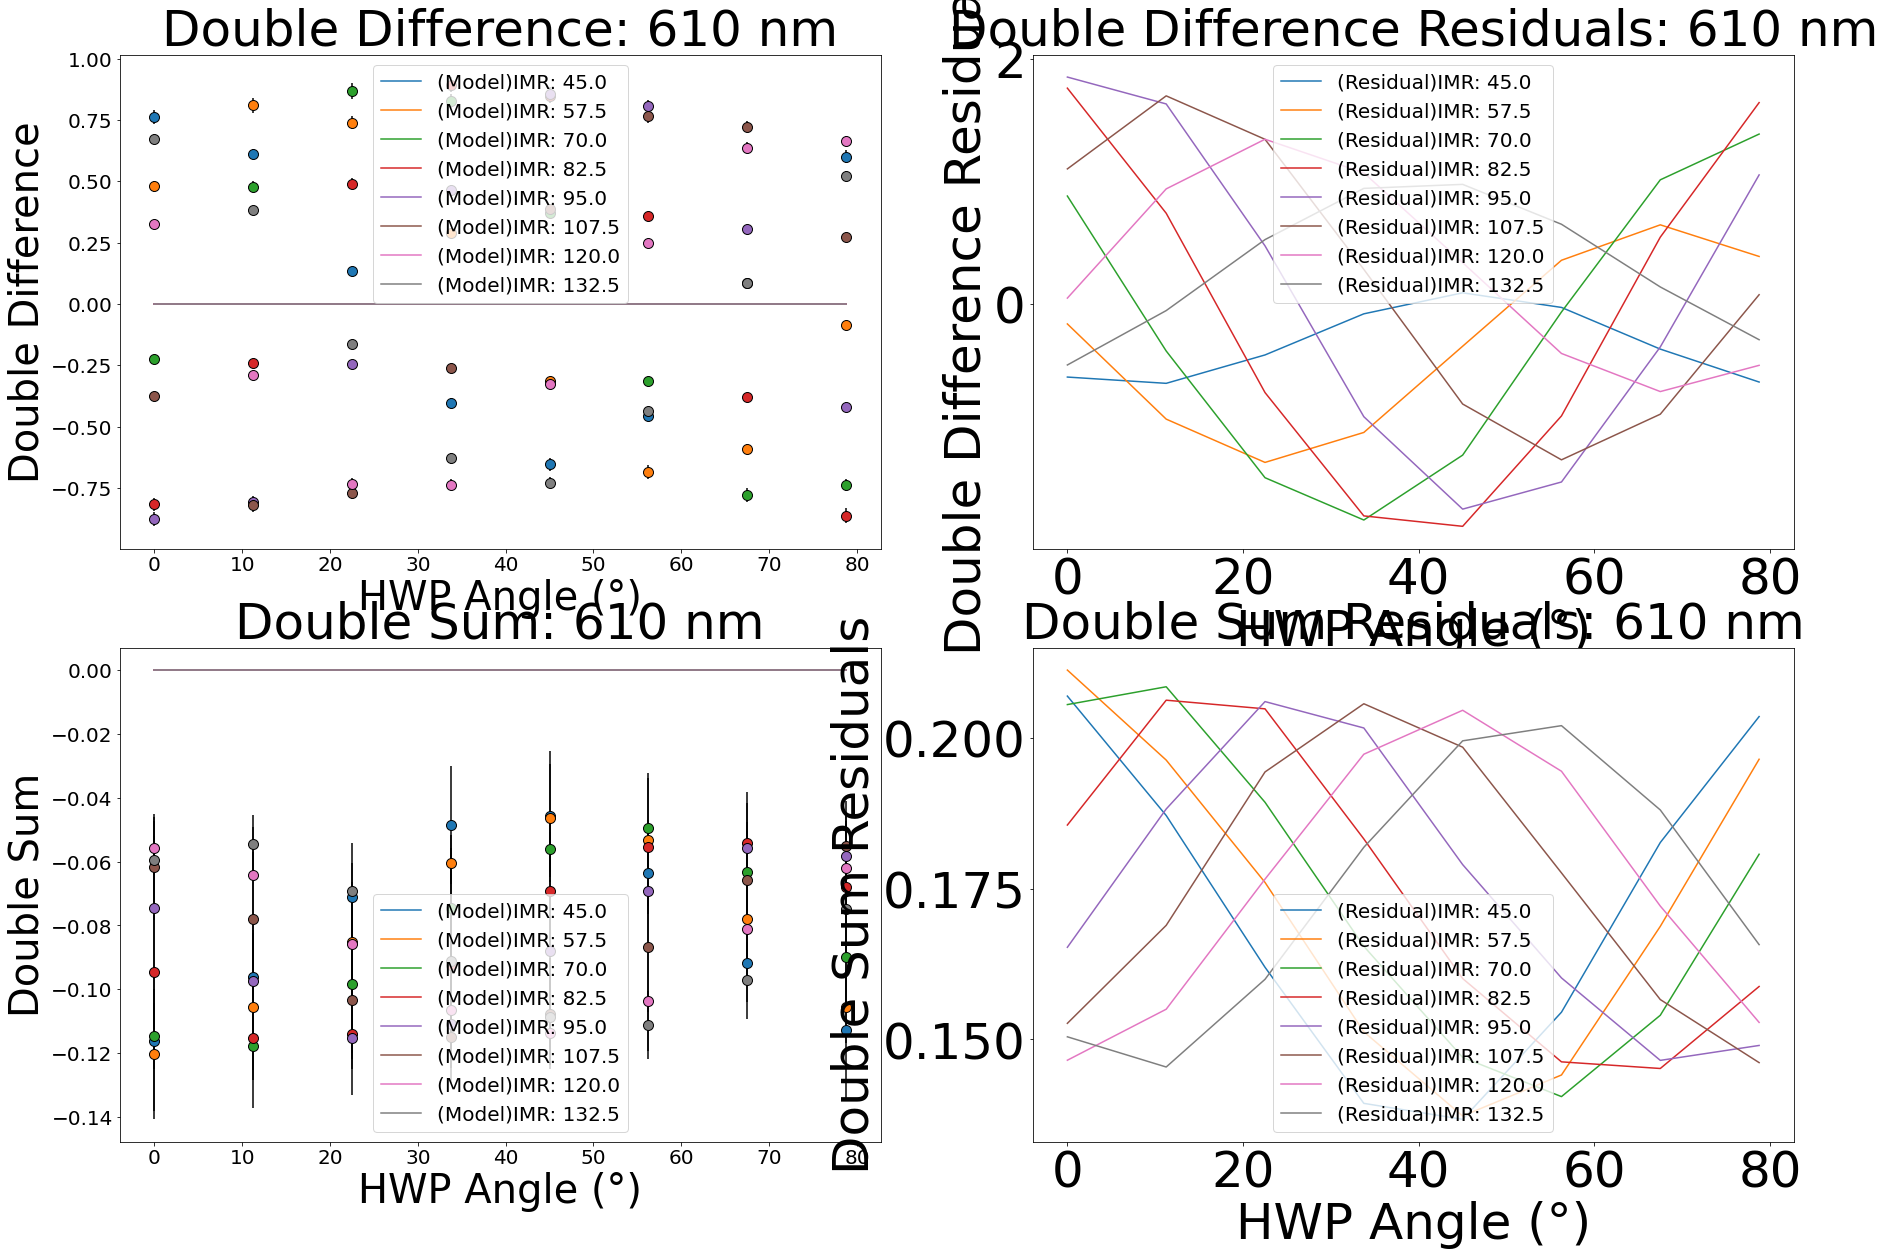

In [5]:
# Small value to remove error bars
log_f = -10

# Defining model angles
model_angles = np.linspace(0, 90, 100)

# Choosing matrix model
model = instrument_matrices.full_system_mueller_matrix

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits - having zeros for angles that're too large
theta_pol = 0
delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 1.2  # Add your actual em_gain value
delta_HWP = 0.432  # Add your actual delta_HWP value
offset_HWP = 0  # Add your actual offset_HWP value
delta_derot = 0.223  # Add your actual delta_derot value
offset_derot = 0  # Add your actual offset_derot value
delta_opts = 0  # Add your actual delta_opts value
epsilon_opts = 0  # Add your actual epsilon_opts value
rot_opts = 0  # Add your actual rot_opts value
delta_FLC = 0.5  # Add your actual delta_FLC value
rot_FLC = 0  # Add your actual rot_FLC value

initial_guess = np.array([ \
    theta_pol,
    delta_HWP,
    offset_HWP,
    delta_derot,
    offset_derot,
    delta_opts,
    epsilon_opts,
    rot_opts,
    delta_FLC,
    rot_FLC,
    em_gain
])

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Calculating initial model and residuals
initial_model = instrument_matrices.internal_calibration_mueller_matrix(theta_pol,
    model, fixed_params, HWP_angs, IMR_angs)
initial_residuals = initial_model - reshaped_data

# Plotting the initial model and residuals
data_plotting.plot_single_model_and_residuals(angles, angles, -initial_model, data, 
    initial_residuals, stds, log_f, wavelength, fig_dimensions = (30, 20))

# Plotting just the data with no model
data_plotting.plot_single_model_and_residuals(angles, angles, np.zeros(np.shape(initial_model)), data, 
    initial_residuals, stds, log_f, wavelength, fig_dimensions = (30, 20))

# FLC ~ HWP behaviour and FLC angle restrained from -5 to 5 degrees, HWP and IMR basically restrained

In [6]:
import numpy as np
from scipy.optimize import minimize

# Small value to remove error bars
log_f = -10

# Defining model angles
model_angles = np.linspace(0, 90, 100)

# List to store all the solutions 
solns = []

# Initial guess based on the parameters you want to minimize
initial_guess = np.array([theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, 
    delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, em_gain])

all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Fixed parameters not included in the fitting process
fixed_params = [delta_m3, epsilon_m3, offset_m3]

# Define the bounds for the parameters (including em_gain)
bounds = [
    (-5, 5),  # theta_pol
    (delta_HWP - delta_HWP * 0.1, 0.5),  # delta_HWP
    (-5, 5),  # offset_HWP
    (delta_derot - delta_derot * 0.1, delta_derot + delta_derot * 0.1),  # delta_derot
    (-1, 1),  # offset_derot
    (-0.5, 0.5),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    (0.4, 0.6),  # delta_FLC
    (-5, 5),  # rot_FLC
    (0, 2)  # em_gain
]

# Defining the negative log-likelihood function
def nll(params, model, HWP_angs, IMR_angs, data, stds):
    theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, em_gain = params
    delta_m3, epsilon_m3, offset_m3 = fixed_params
    all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
        delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
        rot_FLC, em_gain]
    this_model = -instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs)
    residuals = np.abs(this_model - data)
    
    # Debug print shapes
    # print("Model shape:", this_model.shape)
    # print("Data shape:", data.shape)
    # print("Stds shape:", stds.shape)
    
    likelihood = np.sum((residuals / stds) ** 2)
    return likelihood

# Initialize variables for the iterative minimization process
counter = 0
initial_likelihood = 100
post_likelihood = 90

# Starting off with the initial guess
model = instrument_matrices.full_system_mueller_matrix
initial_model = -instrument_matrices.internal_calibration_mueller_matrix(initial_guess[0], model, all_params, HWP_angs, IMR_angs)

while post_likelihood < (initial_likelihood - 1e-6):  # Introduce a small tolerance for convergence

    counter += 1

    initial_likelihood = post_likelihood

    # Calculate the initial model and residuals
    initial_model = -instrument_matrices.internal_calibration_mueller_matrix(initial_guess[0], model, all_params, HWP_angs, IMR_angs)
    initial_residuals = np.abs(initial_model - reshaped_data)

    initial_likelihood = np.sum((initial_residuals / reshaped_stds) ** 2)

    print("Initial Likelihood: " + str(initial_likelihood))

    # Minimize the negative log-likelihood
    minimize_args = (model, HWP_angs, IMR_angs, reshaped_data, reshaped_stds)
    soln = minimize(nll, initial_guess, args=minimize_args, bounds=bounds, method="Nelder-Mead")

    # Save the solution
    solns.append(soln)

    # Recalculate the likelihood with the new solution
    theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, em_gain = soln.x
    delta_m3, epsilon_m3, offset_m3 = fixed_params
    all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
        delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
        rot_FLC, em_gain]
    post_likelihood = np.sum((-instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs) - reshaped_data) / reshaped_stds ** 2)

    print("Iteration #" + str(counter) + ": " + str(post_likelihood))

    print("MAXIMUM LIKELIHOOD ESTIMATES")
    print("")
    print("theta_pol (degrees): " + str(theta_pol))
    print("delta_HWP (waves): " + str(delta_HWP))
    print("offset_HWP (degrees): " + str(offset_HWP))
    print("delta_derot (waves): " + str(delta_derot))
    print("offset_derot (degrees): " + str(offset_derot))
    print("delta_opts (waves): " + str(delta_opts))
    print("epsilon_opts: " + str(epsilon_opts))
    print("rot_opts (degrees): " + str(rot_opts))
    print("delta_FLC (waves): " + str(delta_FLC))
    print("rot_FLC (degrees): " + str(rot_FLC))
    print("em_gain: " + str(em_gain))

    reshaped_data = general.reshape_and_flatten(data)
    reshaped_stds = general.reshape_and_flatten(stds)

    model_1 = -instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs)
    residuals_1 = model_1 - reshaped_data

    data_plotting.plot_single_model_and_residuals(angles, angles, model_1, data, 
        residuals_1, stds, log_f, wavelength, fig_dimensions = (30, 20))

    # Reset initial guess
    initial_guess = soln.x

    print("Post Likelihood: " + str(post_likelihood))

print("End of Optimization")


Initial Likelihood: 48655.485837240674


KeyboardInterrupt: 

# Saving Final Fit

In [13]:
# import numpy as np

save_string = "scipy_minimize_20230914_" + str(wavelength) \
    + "nm_restrictive_HWP_and_IMR.npy"
np.save(save_string, soln.x)